<a href="https://colab.research.google.com/github/sameer203/Tensorflow_/blob/main/08_transfer_learning_tensorflow_fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Oct 25 12:18:22 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Creating the Helper function

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2021-10-25 12:18:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-10-25 12:18:23 (58.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# import helper functions
import helper_functions

In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, walk_through_dir

### Input Data

In [5]:
# Input Data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

unzip_data("10_food_classes_10_percent.zip")

--2021-10-25 12:18:25--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.119.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M  76.3MB/s    in 2.1s    

2021-10-25 12:18:28 (76.3 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [6]:
walk_through_dir("10_food_classes_10_percent")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/train'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_wings'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/pizza'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/steak'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/ramen'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/grilled_salmon'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/sushi'.
There are 0 directories and 75 images in '10_food_classes_10_percent/train/fried_rice'.
There are 0 directories and 75 images in '10_food_classes_10_percent/tra

In [7]:
#Create training and test directory paths

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [8]:
import tensorflow as tf

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_10_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [9]:
train_data_10_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [10]:
train_data_10_percent.class_names

['chicken_curry',
 'chicken_wings',
 'fried_rice',
 'grilled_salmon',
 'hamburger',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

In [11]:
#for images, labels in train_data_10_percent.take(1):
  #print(images, labels)

### Model 0: Building a transfer learning model using the Keras Function

In [12]:
# Create the base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# Freeze the base model
base_model.trainable = False

# Create inputs into model
inputs = tf.keras.layers.Input(shape=(224, 224,3), name="input_layer")

# Normalize the inputs
#x = tf.keras.experimental.preprosessing.Rescaling(1./255)(inputs)

# Pass the inputs to base model
x = base_model(inputs)
print(f"Shapes after passing inputs through base model:{x.shape}")

# Average pool the outputs of the base model
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"Shapes after GlobalAveragePooling2D:{x.shape}")

# Create the output activation layer
outputs = tf.keras.layers.Dense(10, activation="softmax", name="output_layer")(x)

# Combine the inputs and outputs
model_0 = tf.keras.Model(inputs, outputs)


16719872/16705208 [==============================] - 0s 0us/step
Shapes after passing inputs through base model:(None, 7, 7, 1280)
Shapes after GlobalAveragePooling2D:(None, 1280)


In [13]:
# Compile the model
model_0.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [14]:
# Fit the model
history_0 = model_0.fit(train_data_10_percent,
            epochs=5,
            steps_per_epoch=len(train_data_10_percent),
            validation_data=test_data,
            validation_steps=int(0.25 * len(test_data)),
            callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                   experiment_name="model_0")])

Saving TensorBoard log files to: tensorflow_hub/model_0/20211025-121836
Epoch 1/5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


24/24 [==============================] - 25s 214ms/step - loss: 1.8871 - accuracy: 0.4000 - val_loss: 1.3384 - val_accuracy: 0.7023
Epoch 2/5
24/24 [==============================] - 4s 174ms/step - loss: 1.1383 - accuracy: 0.7387 - val_loss: 0.9271 - val_accuracy: 0.7780
Epoch 3/5
24/24 [==============================] - 4s 171ms/step - loss: 0.8371 - accuracy: 0.7987 - val_loss: 0.7415 - val_accuracy: 0.8191
Epoch 4/5
24/24 [==============================] - 3s 128ms/step - loss: 0.6892 - accuracy: 0.8373 - val_loss: 0.6652 - val_accuracy: 0.8289
Epoch 5/5
24/24 [==============================] - 4s 171ms/step - loss: 0.5842 - accuracy: 0.8600 - val_loss: 0.6220 - val_accuracy: 0.8207


In [15]:
# Check the layersin base model
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer)

0 <keras.engine.input_layer.InputLayer object at 0x7f54b0b525d0>
1 <keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7f54afcbafd0>
2 <keras.layers.preprocessing.normalization.Normalization object at 0x7f54b0df6c10>
3 <keras.layers.convolutional.ZeroPadding2D object at 0x7f54afc71350>
4 <keras.layers.convolutional.Conv2D object at 0x7f54afc11550>
5 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54afc46d90>
6 <keras.layers.core.Activation object at 0x7f54afccb7d0>
7 <keras.layers.convolutional.DepthwiseConv2D object at 0x7f54afb9aa10>
8 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f54afdb8690>
9 <keras.layers.core.Activation object at 0x7f54afbbc110>
10 <keras.layers.pooling.GlobalAveragePooling2D object at 0x7f54afbbc810>
11 <keras.layers.core.Reshape object at 0x7f54afbca050>
12 <keras.layers.convolutional.Conv2D object at 0x7f54afb4f090>
13 <keras.layers.convolutional.Conv2D object at 0x7f54afb54f

In [16]:
# summary
base_model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, None, None, 3 7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization[0][0]              
_____________________________________________________________________________________

In [17]:
model_0.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,381
Trainable params: 12,810
Non-trainable params: 4,049,571
_________________________________________________________________


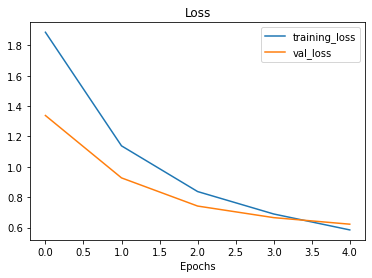

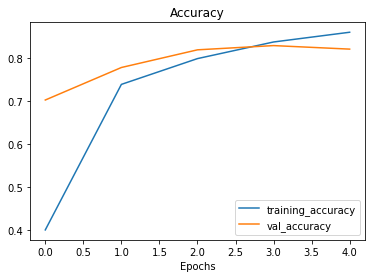

In [18]:
plot_loss_curves(history_0)

### Getting a feature vector from a trained model

In [19]:
# Create a random tensor
input_shape = (1,4,4,3)

tf.random.set_seed(42)
input_tensor = tf.random.normal(input_shape)
print(f"Random input tensor: \n {input_tensor}\n")

Random input tensor: 
 [[[[ 0.3274685  -0.8426258   0.3194337 ]
   [-1.4075519  -2.3880599  -1.0392479 ]
   [-0.5573232   0.539707    1.6994323 ]
   [ 0.28893656 -1.5066116  -0.2645474 ]]

  [[-0.59722406 -1.9171132  -0.62044144]
   [ 0.8504023  -0.40604794 -3.0258412 ]
   [ 0.9058464   0.29855987 -0.22561555]
   [-0.7616443  -1.8917141  -0.93847126]]

  [[ 0.77852213 -0.47338897  0.97772694]
   [ 0.24694404  0.20573747 -0.5256233 ]
   [ 0.32410017  0.02545409 -0.10638497]
   [-0.6369475   1.1603122   0.2507359 ]]

  [[-0.41728503  0.4012578  -1.4145443 ]
   [-0.5931857  -1.6617213   0.33567193]
   [ 0.10815629  0.23479682 -0.56668764]
   [-0.35819843  0.88698614  0.52744764]]]]



In [20]:
#pass the random tensor to the global average pooling 2d
global_average_pooled_tensor = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
print(f"2D global Average pooled Tensor: \n {global_average_pooled_tensor}\n")

2D global Average pooled Tensor: 
 [[-0.09368646 -0.45840448 -0.2885598 ]]



In [21]:
global_average_pooled_tensor.shape

TensorShape([1, 3])

In [22]:
#replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

In [23]:
global_max_pooled_tensor = tf.keras.layers.GlobalMaxPool2D()(input_tensor)
print(f"2D global Average pooled Tensor: \n {global_max_pooled_tensor}\n")
global_max_pooled_tensor.shape

2D global Average pooled Tensor: 
 [[0.9058464 1.1603122 1.6994323]]



TensorShape([1, 3])

In [24]:
#replicate the GlobalAveragePool2D layer
tf.reduce_mean(input_tensor, axis=[1,2])

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[-0.09368646, -0.45840448, -0.2885598 ]], dtype=float32)>

### Model 1 - Feature Extraction with 1% Data with Data agumentation

In [25]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip

unzip_data("10_food_classes_1_percent.zip")

--2021-10-25 12:21:44--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_1_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.143.128, 173.194.69.128, 173.194.79.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.143.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 133612354 (127M) [application/zip]
Saving to: ‘10_food_classes_1_percent.zip’

10_food_classes_1_p 100%[===================>] 127.42M  68.1MB/s    in 1.9s    

2021-10-25 12:21:46 (68.1 MB/s) - ‘10_food_classes_1_percent.zip’ saved [133612354/133612354]



In [26]:
walk_through_dir("10_food_classes_1_percent")

There are 2 directories and 0 images in '10_food_classes_1_percent'.
There are 10 directories and 0 images in '10_food_classes_1_percent/train'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_wings'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/pizza'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/steak'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ice_cream'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/ramen'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/chicken_curry'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/grilled_salmon'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/sushi'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/fried_rice'.
There are 0 directories and 7 images in '10_food_classes_1_percent/train/hamburger'.
There a

In [27]:
#Create training and test directory paths

train_dir_1_percent = "10_food_classes_1_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

In [30]:
# Data loaders
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_data_1_percent = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir_1_percent,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                            image_size=IMG_SIZE,
                                                                            label_mode="categorical",
                                                                            batch_size=BATCH_SIZE)

Found 70 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [31]:
train_data_1_percent

<BatchDataset shapes: ((None, 224, 224, 3), (None, 10)), types: (tf.float32, tf.float32)>

In [ ]:
# using Data Augumentation within the model
